<a href="https://colab.research.google.com/github/j-hartmann/SFR/blob/main/SFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Code Appendix

## **Using Text Analysis in Service Failure Recovery: Theory, Workflows, and Models**

#### Villarroel Ordenes, Packard, Proserpio, and Hartmann (2024)

**Dictionaries**

In [ ]:
# install libraries
!pip install vaderSentiment

In [ ]:
# load libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# example sentences
sentences = ["I'm disappointed and frustrated how ABC treat their customers...", "The service experience was not bad", "AMAZING 😍"]

# extract sentiment
analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

I'm disappointed and frustrated how ABC treat their customers...- {'neg': 0.428, 'neu': 0.395, 'pos': 0.178, 'compound': -0.5859}
The service experience was not bad------------------------------- {'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.431}
AMAZING 😍-------------------------------------------------------- {'neg': 0.0, 'neu': 0.285, 'pos': 0.715, 'compound': 0.8192}


**Topic Models**

In [ ]:
# install libraries
!pip install lda

In [ ]:
# load libraries
import lda
import lda.datasets
import numpy as np

In [ ]:
# load dataset
X = lda.datasets.load_reuters()
vocab = lda.datasets.load_reuters_vocab()
titles = lda.datasets.load_reuters_titles()

In [ ]:
# run topic model
model = lda.LDA(n_topics=10, n_iter=1500, random_state=42)
model.fit(X)
topic_word = model.topic_word_
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
  print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: harriman u.s clinton churchill president paris british ambassador
Topic 1: yeltsin president political russian russia party kremlin government
Topic 2: elvis music miami fans versace cunanan police city
Topic 3: pope vatican surgery paul catholic rome roman pontiff
Topic 4: church years people told first last year time
Topic 5: mother teresa order heart charity nuns hospital calcutta
Topic 6: city germany german war century christian exhibition million
Topic 7: bernardin east peace south michael romania prize government
Topic 8: film catholic simpson wright life festival women bishop
Topic 9: charles prince king royal diana queen bowles parker


**Supervised Machine Learning and Deep Learning**

In [ ]:
# install libraries
!pip install ucimlrepo

In [ ]:
# load libraries
import pandas as pd
import string
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

In [ ]:
# import data
drug_reviews_drugs_com = fetch_ucirepo(id=462)
data = drug_reviews_drugs_com.data.features

# clean data
data['review_clean'] = data['review'].str.replace('[{}]'.format(string.punctuation), '')
data = data.fillna({'review':''})

# create a sentiment label column
data['sentiment'] = data['rating'].apply(lambda rating : +1 if rating > 5 else -1)

# sample and balance data
data = data.groupby('sentiment').sample(n = 5000, random_state = 42)

# create a train and test split
train_data, test_data = train_test_split(data, test_size = 0.20)
print('Size of train_data is:', train_data.shape)
print('Size of test_data is:', test_data.shape)

Size of train_data is: (8000, 8)
Size of test_data is: (2000, 8)


In [ ]:
# extract features (vectorize)
vectorizer = HashingVectorizer()
train_matrix = vectorizer.transform(train_data['review_clean'].values.astype('U'))
test_matrix = vectorizer.transform(test_data['review_clean'].values.astype('U'))

# train random forest
random_forest = RandomForestClassifier()
model = random_forest.fit(train_matrix, train_data['sentiment'])

# predict and measure performance on test data
y_pred = model.predict(test_matrix)
f1_score(y_pred, test_data['sentiment'])

0.740253164556962

Text(50.722222222222214, 0.5, 'Truth')

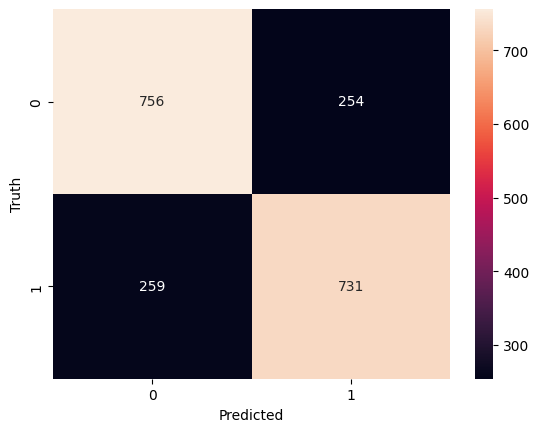

In [ ]:
# plot confusion matrix
cm = confusion_matrix(test_data.sentiment,y_pred)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Embeddings**

In [ ]:
# install libraries
!pip install -U sentence-transformers

In [ ]:
# load libraries
from sentence_transformers import SentenceTransformer, util

In [ ]:
# import model
model = SentenceTransformer('all-MiniLM-L6-v2')

sentence1 = ['The service is awesome!']
sentence2 = ['What a nice customer service.']

embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)

In [ ]:
# check similarities between sentences
print('The cosine similarity is:', util.cos_sim(embedding1, embedding2).item())

The cosine similarity is: 0.5451609492301941


**Language Models and Generative AI**

In [41]:
# import libraries
from transformers import pipeline
import pandas as pd
from google.colab import files

*Run SiEBERT, a language model specialized on binary sentiment analysis.*

In [33]:
# import model
get_sentiment = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english", device = 0)

In [34]:
# predict sentiment of a single sentence
get_sentiment("My flight was cancelled. Where can I request a refund?")

[{'label': 'NEGATIVE', 'score': 0.9993242025375366}]

In [35]:
# predict sentiment of multiple documents

# load data from GitHub
!wget https://raw.githubusercontent.com/shivang16/movieReview/master/movie_review.csv
d = pd.read_csv("/content/movie_review.csv")

# sample and preprocess data
d = d.iloc[0:100]  # sample to first 100 reviews
text_column = 'text'  # select text column
texts = d[text_column].astype('str').tolist()

--2024-05-14 19:42:27--  https://raw.githubusercontent.com/shivang16/movieReview/master/movie_review.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9150992 (8.7M) [text/plain]
Saving to: ‘movie_review.csv.3’

movie_review.csv.3  100%[===================>]   8.73M  --.-KB/s    in 0.07s   

2024-05-14 19:42:28 (131 MB/s) - ‘movie_review.csv.3’ saved [9150992/9150992]



In [37]:
# print predictions
p = pd.DataFrame(get_sentiment(texts))['label']
p.value_counts()  # check sentiment distribution

label
POSITIVE    61
NEGATIVE    39
Name: count, dtype: int64

In [38]:
# add predictions to original dataframe
d['sentiment'] = p
d[[text_column, 'sentiment']].head()

,text,sentiment
0,films adapted from comic books have had plenty...,NEGATIVE
1,"for starters , it was created by alan moore ( ...",POSITIVE
2,to say moore and campbell thoroughly researche...,POSITIVE
3,"the book ( or "" graphic novel , "" if you will ...",NEGATIVE
4,"in other words , don't dismiss this film becau...",POSITIVE


In [39]:
# save results to csv
output_filename = 'Sentiment_Predictions.csv'  # name your output file
d.to_csv(output_filename, index=False)

In [42]:
# download output file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

*Run a fine-tuned language model for emotion extraction.*

In [ ]:
# import model
get_emotions = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device = 0)

In [ ]:
# predict emotions
get_emotions("This was by far the best service experience I've ever made!")

[[{'label': 'anger', 'score': 0.005697187967598438},
  {'label': 'disgust', 'score': 0.005230925511568785},
  {'label': 'fear', 'score': 0.0024537532590329647},
  {'label': 'joy', 'score': 0.7304487228393555},
  {'label': 'neutral', 'score': 0.09406807273626328},
  {'label': 'sadness', 'score': 0.002163215074688196},
  {'label': 'surprise', 'score': 0.15993811190128326}]]

*Run Microsoft's Phi-3-mini for zero-shot aspect-based sentiment analysis.*

In [ ]:
# check gpu
!nvidia-smi

Tue Apr 23 12:07:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              26W /  70W |   4815MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# install libraries
!pip install transformers accelerate bitsandbytes

In [ ]:
# load libraries
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [ ]:
# load model
torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

In [ ]:
# predict sentiment
messages = [
    {"role": "system", "content": "You are a helpful digital assistant. Please provide safe, ethical and accurate information to the user."},
    {"role": "user", "content": "Your task is to predict the sentiment of the following sentence: 'I'm disappointed by the service quality but pleasantly surprised by the price.'. Return the sentiment (positive, negative, neutral, or mixed) and the respective aspect of the sentiment in JSON format. Report the sentiment for each aspect separately."},
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 {
  "overall_sentiment": "mixed",
  "aspects": {
    "service_quality": {
      "sentiment": "negative",
      "reason": "disappointed"
    },
    "price": {
      "sentiment": "positive",
      "reason": "pleasantly surprised"
    }
  }
}


**References and Resources:**
* https://github.com/cjhutto/vaderSentiment
* https://github.com/lda-project/lda
* https://mlarchive.com/machine-learning/sentiment-analysis-with-random-forest/
* https://huggingface.co/siebert/sentiment-roberta-large-english
* https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
* https://huggingface.co/microsoft/Phi-3-mini-128k-instruct
* Krugmann, J.O., Hartmann, J. Sentiment Analysis in the Age of Generative AI. *Customer Needs and Solutions* 11, 3 (2024). https://doi.org/10.1007/s40547-024-00143-4.
